# Regression using DL methods

Dataset: https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data

We study the prediction of price of US airbnb in 2020. We adopt the different DL methods to make the predictions. In addition, we extract the important features from the models. This gives us insight to understand the important factors and the price. We compare the performance of the different models and the summary.

In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() # to avoid bugs from shap. We downgrade the tensorflow 1.x
tf.compat.v1.keras.backend.get_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
shap.initjs()

Load data

In [3]:
train_X = pd.read_csv('train_X.csv', index_col=0)
feature_col = list(train_X.columns)
train_X = train_X.values
test_X = pd.read_csv('test_X.csv', index_col=0).values
val_X = pd.read_csv('val_X.csv', index_col=0).values

train_y = pd.read_csv('train_y.csv', index_col=0).values
test_y = pd.read_csv('test_y.csv', index_col=0).values
val_y = pd.read_csv('val_y.csv', index_col=0).values

In [4]:
epochs = 100
batch_size = 64
verbose = 2

# Dense model

In [5]:
input_shape=(train_X.shape[1],)

In [6]:
def dense_model(input_shape):
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=input_shape))
    model.add(Dropout(.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [7]:
%%capture --no-display
model = dense_model(input_shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              230400    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 1,281,025
Trainable params: 1,281,025
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Train on 28313 samples, validate on 3146 samples
Epoch 1/100
28313/28313 - 6s - loss: 104.7190 - val_loss: 96.7861
Epoch 2/100
28313/28313 - 2s - loss: 96.0249 - val_loss: 93.7271
Epoch 3/100
28313/28313 - 2s - loss: 93.9285 - val_loss: 92.1832
Epoch 4/100
28313/28313 - 2s - loss: 92.4253 - val_loss: 92.1094
Epoch 5/100
28313/28313 - 2s - loss: 90.6255 - val_loss: 90.5193
Epoch 6/100
28313/28313 - 2s - loss: 89.1011 - val_loss: 90.8000
Epoch 7/100
28313/28313 - 2s - loss: 87.7946 - val_loss: 88.3761
Epoch 8/100
28313/28313 - 2s - loss: 86.2837 - val_loss: 88.6255
Epoch 9/100
28313/28313 - 2s - loss: 84.8990 - val_loss: 88.3140
Epoch 10/100
28313/28313 - 2s - loss: 83.4088 - val_loss: 87.1632
Epoch 11/100
28313/28313 - 2s - loss: 82.0418 - val_loss: 86.5101
Epoch 12/100
28313/28313 - 2s - loss: 80.7801 - val_loss: 86.1733
Epoch 13/100
28313/28313 - 2s - loss: 79.4296 - val_loss: 86.4643
Epoch 14/100
28313/28313 - 2s - loss: 78.4138 - val_loss: 86.6905
Epoch 15/100
28313/28313 - 2s - los

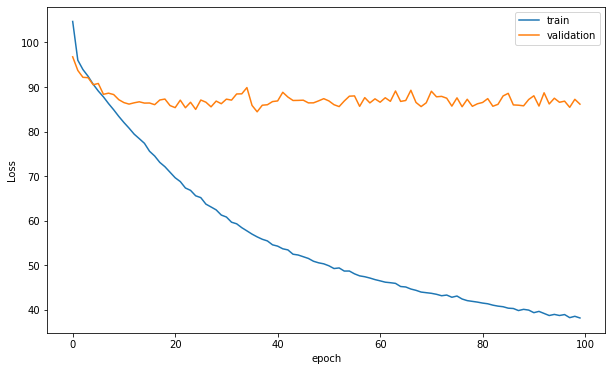

In [10]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [11]:
def performance(truedata, prediction, name=''):
    print(name)
    print('='*15)
    rmse = round(mean_squared_error(truedata, prediction,  squared=False),2)
    mae = round(mean_absolute_error(truedata, prediction),2)
    r2 = round(r2_score(truedata, prediction),2)
    print('rmse:', rmse)
    print('mae: ', mae)
    print('r2:  ', r2)
    return rmse, mae, r2

In [12]:
train_pred = model.predict(train_X)
val_pred = model.predict(val_X)
test_pred = model.predict(test_X)

In [13]:
_ , _ , _ = performance(train_y, train_pred, 'Train set') 

Train set
rmse: 167.44
mae:  31.23
r2:   0.7


In [14]:
_ , _ , _ = performance(val_y, val_pred, 'Validation set') 

Validation set
rmse: 206.09
mae:  86.16
r2:   0.33


In [15]:
dict = {}
dict['Dense'] = performance(test_y, test_pred, 'Test set') 

Test set
rmse: 357.48
mae:  94.12
r2:   0.24


In [16]:
%%capture --no-display
explainer = shap.DeepExplainer(model, train_X[:5000,])
shap_values = explainer.shap_values(test_X[:100,])

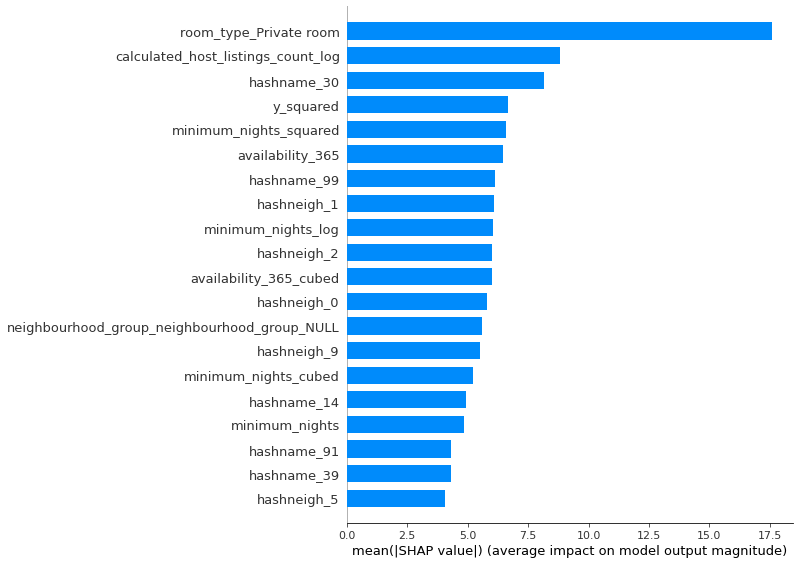

In [17]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = feature_col)

In [18]:
tf.keras.backend.clear_session()

# LSTM model

In [19]:
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
val_X = val_X.reshape(val_X.shape[0], 1, val_X.shape[1])

In [20]:
input_shape = (1, train_X.shape[2])

In [21]:
def lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(1024,input_shape=input_shape,activation='relu',return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(1024,input_shape=input_shape,activation='relu',return_sequences=False))
    model.add(Dropout(.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [22]:
%%capture --no-display
model = lstm_model(input_shape)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 1024)           5115904   
_________________________________________________________________
dropout (Dropout)            (None, 1, 1024)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [24]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Train on 28313 samples, validate on 3146 samples
Epoch 1/100
28313/28313 - 10s - loss: 107.2149 - val_loss: 96.2370
Epoch 2/100
28313/28313 - 7s - loss: 97.5020 - val_loss: 95.1550
Epoch 3/100
28313/28313 - 7s - loss: 95.8165 - val_loss: 93.1326
Epoch 4/100
28313/28313 - 7s - loss: 93.9121 - val_loss: 91.7266
Epoch 5/100
28313/28313 - 7s - loss: 92.5036 - val_loss: 91.0719
Epoch 6/100
28313/28313 - 7s - loss: 90.8102 - val_loss: 90.2150
Epoch 7/100
28313/28313 - 8s - loss: 89.4192 - val_loss: 90.8520
Epoch 8/100
28313/28313 - 8s - loss: 88.0871 - val_loss: 90.4581
Epoch 9/100
28313/28313 - 8s - loss: 86.7316 - val_loss: 89.4070
Epoch 10/100
28313/28313 - 8s - loss: 85.7779 - val_loss: 87.8583
Epoch 11/100
28313/28313 - 8s - loss: 84.8091 - val_loss: 88.0673
Epoch 12/100
28313/28313 - 8s - loss: 83.4643 - val_loss: 88.0222
Epoch 13/100
28313/28313 - 8s - loss: 82.2677 - val_loss: 87.3440
Epoch 14/100
28313/28313 - 8s - loss: 81.5709 - val_loss: 87.3552
Epoch 15/100
28313/28313 - 8s - lo

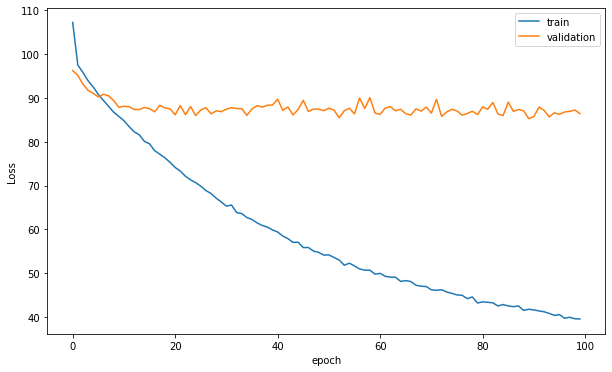

In [25]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [26]:
train_pred = model.predict(train_X)
val_pred = model.predict(val_X)
test_pred = model.predict(test_X)

In [27]:
_ , _ , _ = performance(train_y, train_pred, 'Train set') 

Train set
rmse: 106.61
mae:  29.67
r2:   0.88


In [28]:
_ , _ , _ = performance(val_y, val_pred, 'Validation set') 

Validation set
rmse: 203.63
mae:  86.42
r2:   0.34


In [29]:
dict['LSTM'] = performance(test_y, test_pred, 'Test set') 

Test set
rmse: 279.08
mae:  94.64
r2:   0.54


In [30]:
%%capture --no-display
explainer = shap.DeepExplainer(model, train_X[:5000])
shap_values = explainer.shap_values(test_X[:100])

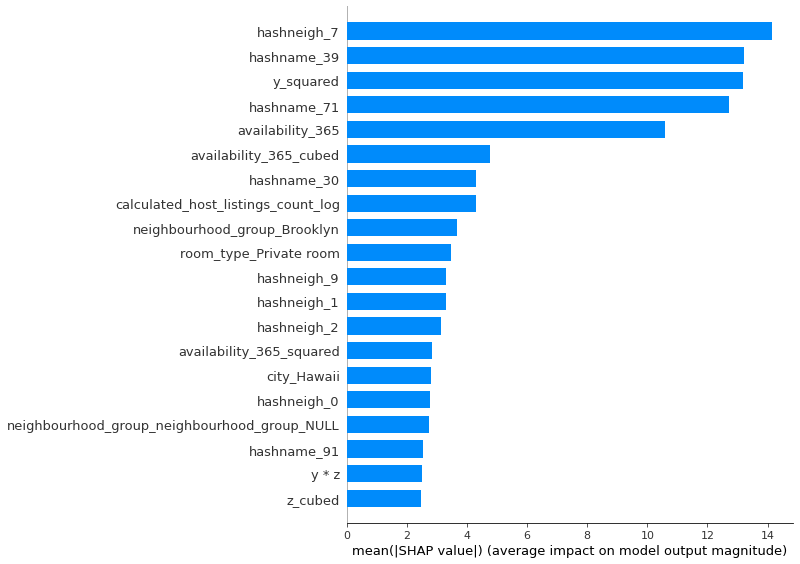

In [31]:
shap.summary_plot(shap_values[0][0], plot_type = 'bar', feature_names=feature_col)

In [32]:
tf.keras.backend.clear_session()

# CNN model

In [33]:
def cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=1024, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(.2))
    model.add(Conv1D(filters=1024, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [34]:
%%capture --no-display
model = cnn_model(input_shape)

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 1024)           230400    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 1024)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1024)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 1024)           1049600   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 1024)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1024)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [36]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Train on 28313 samples, validate on 3146 samples
Epoch 1/100
28313/28313 - 7s - loss: 104.1244 - val_loss: 95.1331
Epoch 2/100
28313/28313 - 4s - loss: 96.0181 - val_loss: 95.7817
Epoch 3/100
28313/28313 - 4s - loss: 93.5673 - val_loss: 92.3582
Epoch 4/100
28313/28313 - 4s - loss: 92.0556 - val_loss: 92.6744
Epoch 5/100
28313/28313 - 4s - loss: 89.9028 - val_loss: 89.0854
Epoch 6/100
28313/28313 - 4s - loss: 87.9596 - val_loss: 88.4848
Epoch 7/100
28313/28313 - 4s - loss: 86.5016 - val_loss: 92.2507
Epoch 8/100
28313/28313 - 4s - loss: 84.9842 - val_loss: 89.7158
Epoch 9/100
28313/28313 - 4s - loss: 83.5473 - val_loss: 88.8515
Epoch 10/100
28313/28313 - 4s - loss: 82.3942 - val_loss: 87.0298
Epoch 11/100
28313/28313 - 4s - loss: 80.5832 - val_loss: 87.4561
Epoch 12/100
28313/28313 - 4s - loss: 79.8179 - val_loss: 86.3164
Epoch 13/100
28313/28313 - 4s - loss: 78.4310 - val_loss: 86.8176
Epoch 14/100
28313/28313 - 4s - loss: 76.7381 - val_loss: 86.4933
Epoch 15/100
28313/28313 - 4s - los

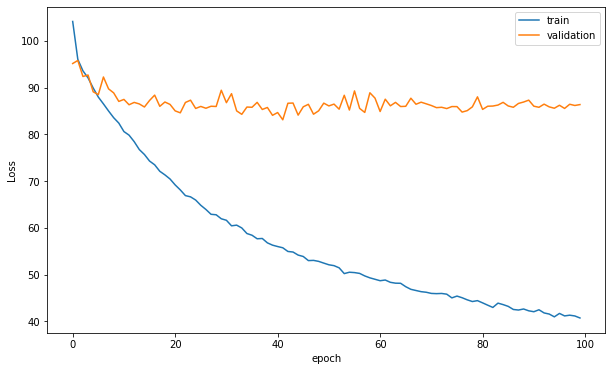

In [37]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [38]:
train_pred = model.predict(train_X)
val_pred = model.predict(val_X)
test_pred = model.predict(test_X)

In [39]:
_ , _ , _ = performance(train_y, train_pred, 'Train set') 

Train set
rmse: 148.05
mae:  30.44
r2:   0.77


In [40]:
_ , _ , _ = performance(val_y, val_pred, 'Validation set') 

Validation set
rmse: 203.58
mae:  86.35
r2:   0.34


In [41]:
dict['CNN'] = performance(test_y, test_pred, 'Test set') 

Test set
rmse: 328.16
mae:  93.0
r2:   0.36


In [42]:
%%capture --no-display
explainer = shap.DeepExplainer(model, train_X[:5000])
shap_values = explainer.shap_values(test_X[:100])

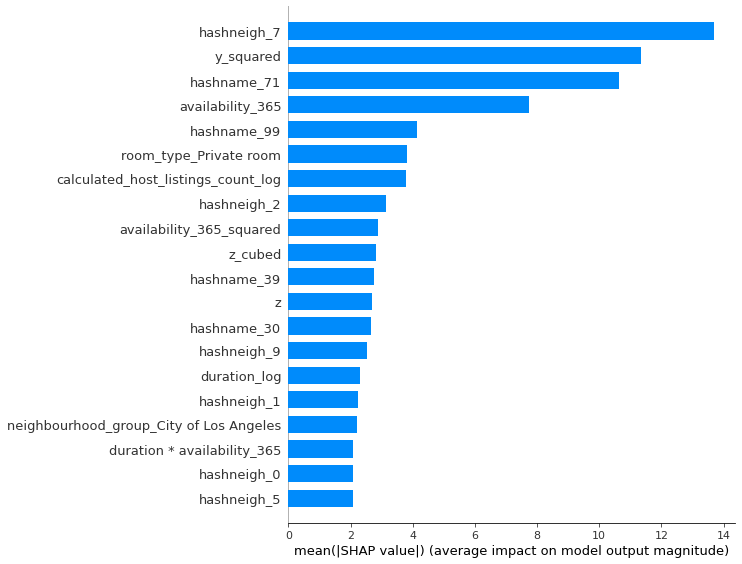

In [43]:
shap.summary_plot(shap_values[0][0], plot_type = 'bar', feature_names = feature_col)

In [44]:
tf.keras.backend.clear_session()

# Bidirectional LSTM model

In [45]:
def bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(512, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(.2))
    model.add(Bidirectional(LSTM(512, activation='relu')))
    model.add(Dropout(.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

In [46]:
%%capture --no-display
model = bilstm_model(input_shape)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 1024)           3018752   
_________________________________________________________________
dropout (Dropout)            (None, 1, 1024)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [48]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Train on 28313 samples, validate on 3146 samples
Epoch 1/100
28313/28313 - 8s - loss: 107.1901 - val_loss: 95.7725
Epoch 2/100
28313/28313 - 6s - loss: 97.1390 - val_loss: 94.8025
Epoch 3/100
28313/28313 - 6s - loss: 95.0184 - val_loss: 94.2139
Epoch 4/100
28313/28313 - 6s - loss: 93.2271 - val_loss: 90.8886
Epoch 5/100
28313/28313 - 6s - loss: 91.7492 - val_loss: 90.1264
Epoch 6/100
28313/28313 - 6s - loss: 89.9294 - val_loss: 89.0209
Epoch 7/100
28313/28313 - 6s - loss: 88.5590 - val_loss: 88.0935
Epoch 8/100
28313/28313 - 6s - loss: 87.3553 - val_loss: 88.8975
Epoch 9/100
28313/28313 - 6s - loss: 85.9231 - val_loss: 88.5408
Epoch 10/100
28313/28313 - 6s - loss: 84.5084 - val_loss: 89.7637
Epoch 11/100
28313/28313 - 6s - loss: 83.4848 - val_loss: 87.1660
Epoch 12/100
28313/28313 - 6s - loss: 82.1397 - val_loss: 86.6276
Epoch 13/100
28313/28313 - 6s - loss: 81.1281 - val_loss: 87.2649
Epoch 14/100
28313/28313 - 6s - loss: 79.9950 - val_loss: 86.8570
Epoch 15/100
28313/28313 - 6s - los

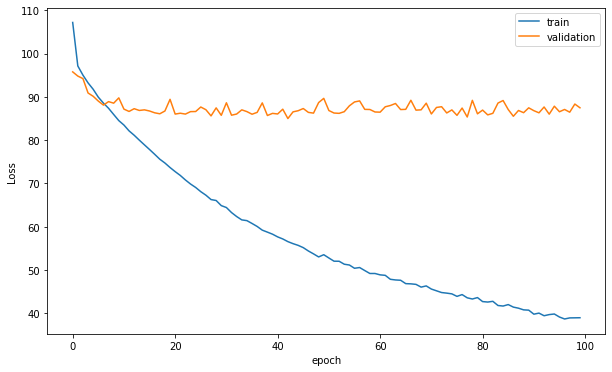

In [49]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [50]:
train_pred = model.predict(train_X)
val_pred = model.predict(val_X)
test_pred = model.predict(test_X)

In [51]:
_ , _ , _ = performance(train_y, train_pred, 'Train set') 

Train set
rmse: 101.64
mae:  29.44
r2:   0.89


In [52]:
_ , _ , _ = performance(val_y, val_pred, 'Validation set') 

Validation set
rmse: 208.28
mae:  87.47
r2:   0.31


In [53]:
dict['BiLSTM'] = performance(test_y, test_pred, 'Test set') 

Test set
rmse: 262.69
mae:  91.98
r2:   0.59


In [54]:
%%capture --no-display
explainer = shap.DeepExplainer(model, train_X[:5000])
shap_values = explainer.shap_values(test_X[:100])

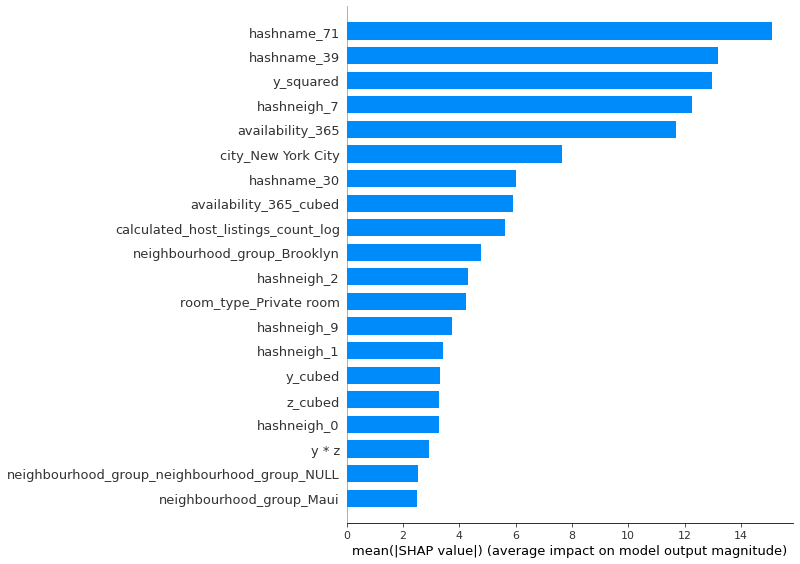

In [55]:
shap.summary_plot(shap_values[0][0], plot_type = 'bar', feature_names = feature_col)

In [56]:
tf.keras.backend.clear_session()

# CNN-LSTM model

In [57]:
train_X = train_X.reshape(train_X.shape[0], 1, 1, train_X.shape[2])
test_X = test_X.reshape(test_X.shape[0], 1, 1, test_X.shape[2])
val_X = val_X.reshape(val_X.shape[0], 1, 1, val_X.shape[2])

In [58]:
input_shape = (None, 1, train_X.shape[3])

In [59]:
def cnnlstm_model(input_shape):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=1024, kernel_size=1, activation='relu'), input_shape=input_shape))
    model.add(Dropout(.2))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(1024, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [60]:
%%capture --no-display
model = cnnlstm_model(input_shape)

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 1, 1024)     230400    
_________________________________________________________________
dropout (Dropout)            (None, None, 1, 1024)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1, 1024)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1024)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 1024)              8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [62]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Train on 28313 samples, validate on 3146 samples
Epoch 1/100
28313/28313 - 9s - loss: 105.1559 - val_loss: 94.9370
Epoch 2/100
28313/28313 - 6s - loss: 96.5095 - val_loss: 93.8474
Epoch 3/100
28313/28313 - 6s - loss: 94.1857 - val_loss: 93.9879
Epoch 4/100
28313/28313 - 6s - loss: 92.3574 - val_loss: 91.5260
Epoch 5/100
28313/28313 - 6s - loss: 90.7235 - val_loss: 89.3113
Epoch 6/100
28313/28313 - 6s - loss: 88.9862 - val_loss: 88.9293
Epoch 7/100
28313/28313 - 6s - loss: 87.5416 - val_loss: 87.5702
Epoch 8/100
28313/28313 - 6s - loss: 85.7081 - val_loss: 87.6296
Epoch 9/100
28313/28313 - 6s - loss: 84.5002 - val_loss: 86.7830
Epoch 10/100
28313/28313 - 6s - loss: 82.8318 - val_loss: 86.8271
Epoch 11/100
28313/28313 - 6s - loss: 81.6042 - val_loss: 86.2289
Epoch 12/100
28313/28313 - 6s - loss: 80.5470 - val_loss: 86.2263
Epoch 13/100
28313/28313 - 6s - loss: 78.9838 - val_loss: 86.4965
Epoch 14/100
28313/28313 - 6s - loss: 78.2397 - val_loss: 88.0889
Epoch 15/100
28313/28313 - 6s - los

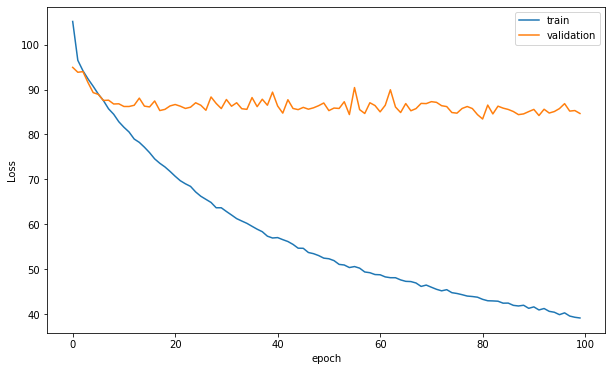

In [63]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [64]:
train_pred = model.predict(train_X)
val_pred = model.predict(val_X)
test_pred = model.predict(test_X)

In [65]:
_ , _ , _ = performance(train_y, train_pred, 'Train set') 

Train set
rmse: 107.7
mae:  30.74
r2:   0.88


In [66]:
_ , _ , _ = performance(val_y, val_pred, 'Validation set') 

Validation set
rmse: 205.21
mae:  84.67
r2:   0.33


In [67]:
dict['CNN-LSTM'] = performance(test_y, test_pred, 'Test set') 

Test set
rmse: 268.65
mae:  89.77
r2:   0.57


In [68]:
%%capture --no-display
explainer = shap.DeepExplainer(model, train_X[:5000])
shap_values = explainer.shap_values(test_X[:100])

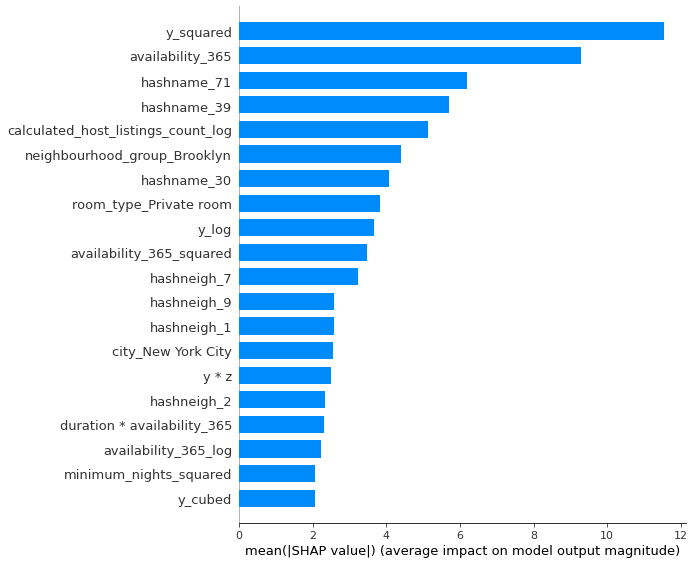

In [69]:
shap.summary_plot(shap_values[0][0][0], plot_type = 'bar', feature_names = feature_col)

In [70]:
tf.keras.backend.clear_session()

# Performance comparison

In [71]:
performance = pd.DataFrame.from_dict(dict)
performance.index = ['rmse','mae','r2']

In [72]:
performance

,Dense,LSTM,CNN,BiLSTM,CNN-LSTM
rmse,357.48,279.08,328.16,262.69,268.65
mae,94.12,94.64,93.00,91.98,89.77
r2,0.24,0.54,0.36,0.59,0.57


# Summary

<li> DL models provide R^2 about 0.5 to 0.6. 
<li> The feature importances can be obtained. The useful features are the description, the location and room type.

# Possible improvement method

<li> We notice that some numerical features obey the multi-modal distribution. They may be applied some special treatment.
<li> We convert the text data into numerics via the hashvectorization. It may be improved by the other transformation methods such as word embedding.
<li> The ensemble method can be used to provide a higher accuracy.